In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import (ImageList, PointsItemList, get_transforms, ResizeMethod, open_image, Tensor, 
                           tensor, Image, imagenet_stats, Flatten, cnn_learner, models, Path)
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
from fastprogress import progress_bar
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn.functional import mse_loss

import tarfile
import boto3

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [6]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [7]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

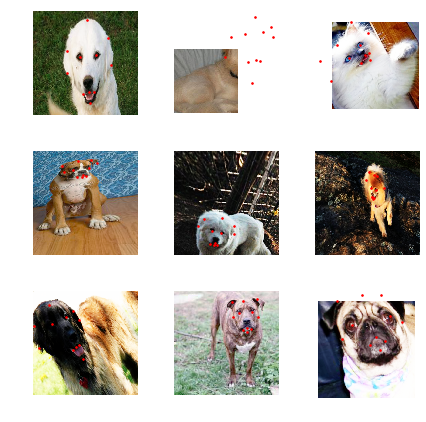

In [8]:
data.show_batch(3, figsize=(6,6))

In [9]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [10]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(51200, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 22),
    Reshape(-1,11,2),
    nn.Tanh()
)

In [11]:
class MSELossFlat(nn.MSELoss):
    def forward(self, input:Tensor, target:Tensor):
        return super().forward(input.view(-1), target.view(-1)) 

mse_loss_flat = MSELossFlat()

learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=mse_loss_flat,
    custom_head=head_reg
).to_fp16()

In [12]:
learn.path = Path('..')

In [13]:
# learn.lr_find()
# learn.recorder.plot()

In [14]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-2), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

In [15]:
learn = learn.load('fastai_resnet34')

In [16]:
# learn.freeze_to(-2)
# learn.fit_one_cycle(
#     10, 
#     slice(1e-3), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-2'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=10)
#     ]
# )

In [17]:
# learn.show_results(rows=10)

In [36]:
data.export('../export.pkl')

In [1]:
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer
import os
import io
import deploy

In [2]:
model_dir = '../models/'
model_file = 'fastai_resnet34.pth'

JPEG_CONTENT_TYPE = 'image/jpeg'

url = "https://mtpcontent-dev.s3.amazonaws.com/ce99060e047d44279e0887270af5afe6.png"

In [3]:
model = deploy.model_fn('fastai_resnet34')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 55987360.06it/s]


In [4]:
img = deploy.input_fn(url)

In [5]:
response = deploy.predict_fn(img, model)